In [1]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
    !git clone https://github.com/pedro15sousa/energy-based-models-compression.git
    %cd energy-based-models-compression/notebooks
else: 
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

Not running on Google Colab. Assuming local environment.


In [2]:
import sys
sys.path.append('..')  # This adds the parent directory (main_folder) to the Python path

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data
import torch.nn.utils.prune as prune

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# Pytorch Summary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install --quiet torchsummary
    from torchsummary import summary

import numpy as np
import pandas as pd
import json
import copy
import random
import copy
import io

## Imports for plotting
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from metrics.classifier import VGG
from metrics.scores import frechet_inception_distance, inception_score
from EBM import DeepEnergyModel
from energy_funcs.cnn import CNNModel
from sampler import Sampler
from callbacks import InceptionScoreCallback, \
    FIDCallback, SamplerCallback, OutlierCallback, \
    GenerateImagesCallback, DummyGenerateImagesCallback

import shutil
if IN_COLAB:
    from google.colab import files

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

pl.seed_everything(43)
random.seed(43)
np.random.seed(43)


/var/folders/pl/gjvtfzbj4691nr_0pszjdspw0000gn/T/ipykernel_66433/1790398400.py:39: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 43


Device:  cpu


In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [5]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True,  drop_last=True,  num_workers=2, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=False, num_workers=2)

In [6]:
if os.path.exists('../saved_models/mnist-classifier-1 (1).pth'):
    # Load the best model
    mnist_classifier = VGG()

    if device == 'cuda':
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth'))
    else:
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth', map_location=torch.device('cpu')))

    mnist_classifier.to(device)
    print("Model already exists and loaded.")
    summary(mnist_classifier, input_size=(1, 28, 28))
else:
    print("Classifier not found in saved_models. Please run the classifier notebook first.")

Model already exists and loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]         147,584
              ReLU-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]         590,080
             ReLU-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         590,080
             ReLU-13          [-1, 256, 14, 14]               0
      

In [7]:
class DownloadCheckpointCallback(pl.Callback):
    def __init__(self, download_dir, every_n_epochs=5):
        """
        Args:
            download_interval (int): Number of epochs between downloads.
            download_dir (str): Directory to download checkpoints to.
        """
        self.every_n_epochs = every_n_epochs
        self.download_dir = download_dir

    def on_train_epoch_end(self, trainer, pl_module, unused=None):
        epoch = trainer.current_epoch
        if epoch % self.every_n_epochs == 0:
            if IN_COLAB:
                shutil.make_archive(f'MNIST_{epoch}', 'zip', self.download_dir)
                files.download(f'MNIST_{epoch}.zip')
            else:
                return

In [9]:
pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
# model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
summary(model, input_size=(1, 28, 28))
model.to(device)
# pl.seed_everything(43)

Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/MNIST.ckpt`


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
             Swish-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
             Swish-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
             Swish-6             [-1, 64, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          36,928
             Swish-8             [-1, 64, 2, 2]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                   [-1, 64]          16,448
            Swish-11                   [-1, 64]               0
           Linear-12                    [-1, 1]              65
         CNNModel-13                       [-1]               0
Total params: 76,993
Trainable params: 

DeepEnergyModel(
  (cnn): CNNModel(
    (cnn_layers): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
      (1): Swish()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Swish()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): Swish()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): Swish()
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Linear(in_features=256, out_features=64, bias=True)
      (10): Swish()
      (11): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [12]:
from torch.quantization import get_default_qconfig, QConfig

# Define per-channel quantization for Conv2d layers
per_channel_qconfig = get_default_qconfig('x86')

# Define per-tensor quantization for Linear layers
per_tensor_qconfig = QConfig(
    activation=torch.quantization.default_observer,
    weight=torch.quantization.default_weight_observer)

# Apply different qconfigs to different layer types
def apply_custom_qconfig(module):
    if isinstance(module, torch.nn.Conv2d):
        module.qconfig = per_channel_qconfig
    elif isinstance(module, torch.nn.Linear):
        module.qconfig = per_tensor_qconfig

model = model.apply(apply_custom_qconfig)


In [300]:
scale = 2 / 255  # Example scale
zero_point = 0  # Example zero-point, for uint8, zero_point is usually 0 or 128

class Swish(nn.Module):
    def forward(self, x):
        x = x * torch.sigmoid(x)
        return x 

class CustomSwish(nn.Module):
    def forward(self, x):
        x = x * torch.sigmoid(x)
        x = torch.quantize_per_tensor(x, scale, zero_point, torch.quint8)
        return x 
    
class DeQuantSwish(nn.Module):
    def __init__(self):
        super().__init__()
        self.dequant = torch.quantization.DeQuantStub()
        self.swish = CustomSwish()

    def forward(self, x):
        x = torch.dequantize(x)
        return self.swish(x)

class ModifiedCNNModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        # Assuming original_model is your quantized model
        # Copy all convolutional and linear layers
        self.conv1 = copy.deepcopy(original_model.cnn_layers[0])
        self.conv2 = copy.deepcopy(original_model.cnn_layers[2])
        self.conv3 = copy.deepcopy(original_model.cnn_layers[4])
        self.conv4 = copy.deepcopy(original_model.cnn_layers[6])
        self.flatten = copy.deepcopy(original_model.cnn_layers[8])
        self.linear1 = copy.deepcopy(original_model.cnn_layers[9])
        self.linear2 = copy.deepcopy(original_model.cnn_layers[11])

        # Create DeQuantSwish layers
        self.swish1 = DeQuantSwish()
        self.swish2 = DeQuantSwish()
        self.swish3 = DeQuantSwish()
        self.swish4 = DeQuantSwish()
        # self.swish5 = Swish()
        self.swish5 = DeQuantSwish()

    def quant_init_input(self, x):
        scale = 0.1  # Example scale
        zero_point = 0  # Example zero-point, for uint8, zero_point is usually 0 or 128

        # Quantize the input tensor
        x = torch.quantize_per_tensor(x, scale, zero_point, torch.quint8)
        return x

    def forward(self, x):
        x = self.quant_init_input(x)
        print("Initial quantized input:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.conv1(x)
        print("After conv1:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish1(x)
        print("After swish1:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.conv2(x)
        print("After conv2:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish2(x)
        print("After swish2:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.conv3(x)
        print("After conv3:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish3(x)
        print("After swish3:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.conv4(x)
        print("After conv4:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish4(x)
        print("After swish4:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.flatten(x)
        print("After flatten:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.linear1(x)
        print("After linear1:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish5(x)
        print("After swish5:",  x.dequantize().mean().item(), x.dequantize().std().item())
       
        print(self.linear2.weight())
        x = self.linear2(x)
        print("After linear2 and before final squeeze:",  x.dequantize().mean().item(), x.dequantize().std().item())
        # x = torch.dequantize(x)
        print(x)
        x = x.squeeze(dim=-1)
        print("Final output:",  x.dequantize().mean().item(), x.dequantize().std().item())

        return x

In [295]:
class DeepEnergyModelQuant(pl.LightningModule):

    def __init__(self, pre_trained_cnn, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = ModifiedCNNModel(pre_trained_cnn)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

In [296]:
def quantize_cnn(model):
    original_cnn = copy.deepcopy(model.cnn)

    original_cnn.to('cpu')  # Ensure the model is on CPU for quantization
    original_cnn.eval()
    # original_cnn.qconfig = torch.ao.quantization.get_default_qconfig('x86')
    # prepared_cnn = torch.ao.quantization.prepare(original_cnn)

    qint8_qconfig = torch.quantization.get_default_qconfig('fbgemm')
    qint8_qconfig = torch.quantization.QConfig(
        activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric),
        weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8)
    )
    original_cnn.qconfig = qint8_qconfig
    prepared_cnn = torch.quantization.prepare(original_cnn)

    # Calibrate with representative data
    with torch.no_grad():
        for data, _ in train_loader:
            prepared_cnn(data)

    # Convert the prepared model to a quantized model
    quantized_cnn = torch.ao.quantization.convert(prepared_cnn)
    return quantized_cnn

In [298]:
quant_ebm = DeepEnergyModelQuant(quantize_cnn(model), img_shape=(1, 28, 28), batch_size=64)
quant_ebm = quantized_model = torch.quantization.quantize_dynamic(quant_ebm, {nn.Linear}, dtype=torch.qint8)

In [299]:
inputs = torch.zeros((1, 1, 28, 28))  # Example input

scale = 0.1  # Example scale
zero_point = 0  # Example zero-point, for uint8, zero_point is usually 0 or 128

# Quantize the input tensor
# quantized_inputs = torch.quantize_per_tensor(inputs, scale, zero_point, torch.quint8)
output = quant_ebm(inputs)
print(output)

Initial quantized input: 0.0 0.0
After conv1: 0.04849306493997574 0.0778631940484047
After swish1: 0.02633989043533802 0.043644655495882034


NotImplementedError: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [MPS, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

MPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:75 [backend fallback]
QuantizedCPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/quantized/cpu/qconv.cpp:1874 [kernel]
BackendSelect: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:290 [backend fallback]
Named: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/TraceTypeManual.cpp:296 [backend fallback]
AutocastCPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:382 [backend fallback]
AutocastCUDA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:249 [backend fallback]
FuncTorchBatched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:710 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


In [249]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + quant_ebm.hparams.img_shape).to(quant_ebm.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = quant_ebm.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Initial quantized input: 0.25094467401504517 0.32412275671958923
After conv1: -0.09343156218528748 0.38856837153434753
After swish1: 0.06799183785915375 0.12107516080141068
After conv2: -0.041992295533418655 0.2259448617696762
After swish2: 0.039308931678533554 0.0673808827996254
After conv3: 0.06490333378314972 0.2453872114419937
After swish3: 0.08097611367702484 0.10600145161151886
After conv4: 0.30669933557510376 0.5385434627532959
After swish4: 0.27927249670028687 0.3370347023010254
After flatten: 0.2792724668979645 0.3370347023010254
After linear1: 0.28163519501686096 0.5041863322257996
After swish5: 0.25306397676467896 0.23728902637958527
QuantizedLinear(in_features=64, out_features=1, scale=0.0031522111967206, zero_point=240, qscheme=torch.per_tensor_affine)
torch.quint8
After linear2 and before final squeeze: -0.7565307021141052 0.0
torch.quint8
Final output: -0.7565307021141052 0.0
Average score for random images: -0.76


In [136]:
with torch.no_grad():
    train_imgs,_ = next(iter(train_loader))
    train_imgs = train_imgs.to(quant_ebm.device)
    train_out = quant_ebm.cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [137]:
@torch.no_grad()
def compare_images(model, img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    print(model.cnn(imgs))
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    # grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    # Normalize the images
    img1 = (img1 + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    img2 = (img2 + 1) / 2
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1.item():4.2f}")
    print(f"Score transformed image: {score2.item():4.2f}")

In [138]:
test_imgs, _ = next(iter(test_loader))
exmp_img = test_imgs[0].to(quant_ebm.device)

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.7964, -0.9720, -0.9918,  ..., -1.0000, -0.9199, -0.9611],
          [-1.0000, -0.8702, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7456, -0.7317, -0.9496,  ..., -0.8088, -1.0000, -1.0000],
          ...,
          [-1.0000, -0.8869, -0.5817,  ..., -0.6367, -1.0000, -1.0000],
          [-0.7858, -0.8599, -1.0000,  ..., -0.8666, -0.8445, -1.0000],
          [-0.8039, -0.4893, -1.0000,  ..., -1.0000, -0.8272, -1.0000]]]])
tensor([[-0.7530],
        [-0.7530]], size=(2, 1), dtype=torch.quint8,
       quantization_scheme=

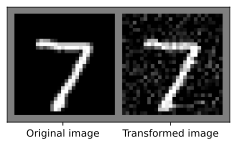

Score original image: -0.75
Score transformed image: -0.75


In [139]:
img_noisy = exmp_img + torch.randn_like(exmp_img) * 0.3
img_noisy.clamp_(min=-1.0, max=1.0)
compare_images(quant_ebm, exmp_img, img_noisy)